<font size = "+3"><strong>Abalone</strong></font>

<font size = "+1"><strong>Predict the age of abalone from its physical measurements</strong></font>

<font face = "calibri">
<p>The abalone is a sea food that's substantially set up in the cold waters of New Zealand, Australia, South Africa, Japan, and the west seacoast of North America. It has extremely rich, flavourful, and largely prized meat that's considered a culinary delicacy.
<p>In this project, we'll try to predict the age of an abalone based on its physical measurements and sex using a Ridge Regression

# Prepare Data

## Import

**Task 1:** Import all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Dropdown

**Task 2:** Create a wrangle function to clean the dataset

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)

    #Rename column headers
    df.columns = ["sex","length","diameter","height","whole_weight","shucked_weight","viscera_weight","shell_weight","rings"]

    df.drop(columns = ["length", "diameter"], inplace = True)
    return df

df = wrangle("abalone.data.csv")
df.head()

,sex,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.095,0.3515,0.1410,0.0775,0.120,8


**Task 3:** Inspect dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4176 non-null   object 
 1   height          4176 non-null   float64
 2   whole_weight    4176 non-null   float64
 3   shucked_weight  4176 non-null   float64
 4   viscera_weight  4176 non-null   float64
 5   shell_weight    4176 non-null   float64
 6   rings           4176 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 228.5+ KB


## Explore

**Task 4.1 (a):** Check the presence of outliers in the target `"rings"` using a boxplot

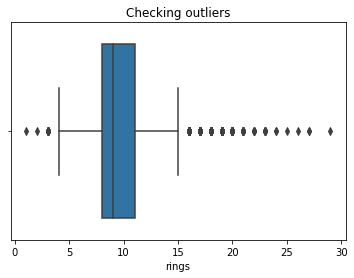

In [4]:
# Check outliers in the target using a boxplot
sns.boxplot(
    data = df,
    x = "rings"
);
plt.title("Checking outliers");

**Task 4.1 (b):** Check the presence of outliers in the target `"rings"` using a histogram

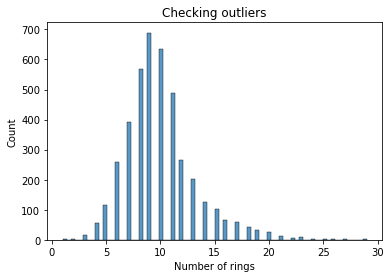

In [5]:
# Check outliers in the target using a histogram
sns.histplot(
    data = df,
    x = "rings"
)
plt.xlabel("Number of rings")
plt.title("Checking outliers");

***Comment:*** The boxplot and the histogram show that there are outliers in the number of rings. However these outliers are needed for this project because an adult abalones can have up to 30 rings, while infants have at least 1 ring.
the outliers 

**Task 5:** Plot a correlation heatmap of the numerical features in the dataframe to check if there are multicollinearity issues

In [6]:
#Check the correlation
corr = df.select_dtypes("number").drop(columns = "rings").corr()
corr

,height,whole_weight,shucked_weight,viscera_weight,shell_weight
height,1.000000,0.819209,0.774957,0.798293,0.817326
whole_weight,0.819209,1.000000,0.969403,0.966372,0.955351
shucked_weight,0.774957,0.969403,1.000000,0.931956,0.882606
viscera_weight,0.798293,0.966372,0.931956,1.000000,0.907647
shell_weight,0.817326,0.955351,0.882606,0.907647,1.000000


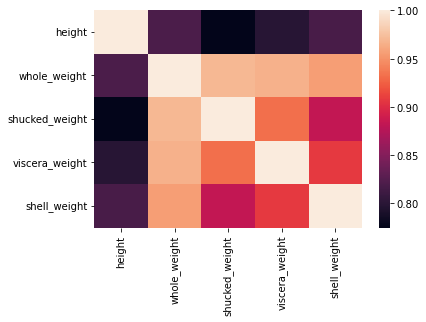

In [7]:
#Plot the correlation matrix
sns.heatmap(corr);

***Comment:*** All the features in the dataset are highly correlated [Drop two of the leaky features i.e. length and diameter]

**Task 6 (a):** Check the distrubution of sex of the abalone

In [8]:
male, female, infant = df.select_dtypes("object").value_counts(normalize = True).round(2)
male, female, infant

(0.37, 0.32, 0.31)

**Task 6 (b):** Visualize the distrubution in (a)

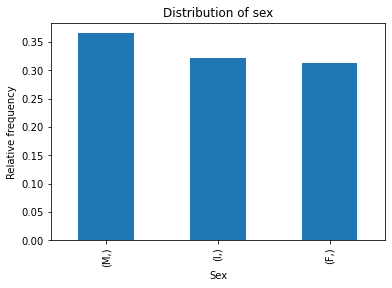

In [9]:
df.select_dtypes("object").value_counts(normalize = True).plot(
    kind = "bar"
)
plt.xlabel("Sex")
plt.ylabel("Relative frequency")
plt.title("Distribution of sex");

***Comment:*** The dataset contains an approximately even distribution of male, female and infant abalones. This is evident in the lengths of the bars (the lengths are almost equal)

**Task 7 (a):** Create a pivot table for the distribution of rings in male, female and infant abalones

In [10]:
sex_pivot = pd.pivot_table(df, "rings", "sex", aggfunc = np.mean).round(1).sort_values("rings")
sex_pivot

,rings
sex,
I,7.9
M,10.7
F,11.1


**Task 7 (b):** Visualize the pivot table in (7 (a))

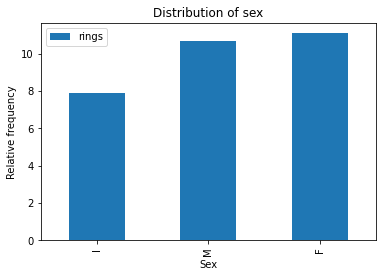

In [11]:
sex_pivot.plot(kind = "bar")
plt.xlabel("Sex")
plt.ylabel("Relative frequency")
plt.title("Distribution of sex");

***Comment:*** The bar chart implies that female and female abalones have approximately the same number of rings, while infant abalones have lesser

## Split

**Task 8:** Create the feature matrix `X` and target vector `y`. The target in this case is `"rings"`. 

In [12]:
target = "rings"
y = df[target]
X = df.drop(columns = target)

**Task 9:** Create a horizontal split using a 20% cut off

In [13]:
cut_off = int(len(y) * 0.80)
X_train, X_test = X.iloc[:cut_off],X.iloc[cut_off:]
y_train, y_test = y.iloc[:cut_off],y.iloc[cut_off:]

# Build Model

## Baseline

**Task 10:** Calculate the baseline mean absolute error of this model

In [14]:
mae_baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
print("Baseline MAE:", round(mae_baseline, 2))

Baseline MAE: 2.45


## Iterate

**Task 11:** Instantiate and train the model

In [15]:
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    Ridge()
)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

## Evaluate

**Task 12:** Calculate the training mean absolute error of this model

In [16]:
mae_train = mean_absolute_error(y_train, y_pred)
print("Training MAE:", round(mae_train, 2))

Training MAE: 1.65


**Task 13:** Calculate the test mean absolute error of this model

In [17]:
mae_test = mean_absolute_error(y_test, model.predict(X_test))
print("Test MAE:", round(mae_test, 2))

Test MAE: 1.52


# Communicate

**Task 14:** Generate an array of predictions of the model

In [18]:
y_pred = model.predict(X_train)
y_pred[:5]

array([ 8.24174951, 10.76071611,  9.53468912,  7.00548035,  7.99816951])

**Task 15:** Calculate the coefficient, intercept and the feature names of the model

In [19]:
coef = model.named_steps["ridge"].coef_
intercept = model.named_steps["ridge"].intercept_
features = model.named_steps["onehotencoder"].get_feature_names()

**Task 16:** Create a series of the features and coefficients

In [20]:
feat_imp = pd.Series(coef, index = features)
feat_imp[:5]

sex_M           0.317323
sex_F           0.379753
sex_I          -0.697076
height          9.680223
whole_weight    7.544120
dtype: float64

**Task 17:** The linear-regression formula

In [21]:
print(f'Age = {intercept}')
for c, i in feat_imp.items():
    print(f' + {c} * {i}')

Age = 6.404731642553026
 + sex_M * 0.3173226136840091
 + sex_F * 0.3797531076962401
 + sex_I * -0.6970757213780902
 + height * 9.680222888626119
 + whole_weight * 7.54412016270099
 + shucked_weight * -16.58428279477896
 + viscera_weight * -5.915937299339261
 + shell_weight * 12.633359948861393


**Task 18:** Create a `get_prediction` function that implements the linear-regression formula

In [22]:
def get_predictions(sex, height, whole_weight, shucked_weight, viscera_weight, shell_weight):
    data = {
        "sex" : sex,
        "height" : height,
        "whole_weight" : whole_weight,
        "shucked_weight" : shucked_weight,
        "viscera_weight" : viscera_weight,
        "shell_weight" : shell_weight
    }
    df = pd.DataFrame(data, index = [0])
    age = model.predict(df).round()[0] + 1.5
    print(f'The age of the abalone from its physical measurements is: {age} years')

**Task 19:** Create an interative dashboard to generate live predictions

In [23]:
interact(
    get_predictions,
    sex = Dropdown(
        options = X_train["sex"].unique()
    ),
    height = FloatSlider(
        value = X_train["height"].mean(),
        steps = 0.1,
        min = X_train["height"].min(),
        max = X_train["height"].max()
    ),
    whole_weight = FloatSlider(
        value = X_train["whole_weight"].mean(),
        steps = 0.1,
        min = X_train["whole_weight"].min(),
        max = X_train["whole_weight"].max()
    ),
    shucked_weight = FloatSlider(
        value = X_train["shucked_weight"].mean(),
        steps = 0.1,
        min = X_train["shucked_weight"].min(),
        max = X_train["shucked_weight"].max()
    ),
    viscera_weight = FloatSlider(
        value = X_train["viscera_weight"].mean(),
        steps = 0.1,
        min = X_train["viscera_weight"].min(),
        max = X_train["viscera_weight"].max()
    ),
    shell_weight = FloatSlider(
        value = X_train["shell_weight"].mean(),
        steps = 0.1,
        min = X_train["shell_weight"].min(),
        max = X_train["shell_weight"].max()
    )
);

interactive(children=(Dropdown(description='sex', options=('M', 'F', 'I'), value='M'), FloatSlider(value=0.139…

# Findings

<font face = "calibri">
<p>
The age of a male and female abalone are approximately equal, assuming the following features are the same:<br>
<ul>
<li>Height</li>
<li>Whole weight</li>
<li>Shucked weight</li>
<li>Viscera weight</li>
<li>Shell weight</li>
</ul>

<p>
Lastly, the age of an infant is always lower than male and female abalones